To locate and recommend to the client which neighbourhood in New York City will be best choice to start a restaurant.

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim 
import os
import folium 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline

print('Libraries imported.')

Libraries imported.


In [2]:
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
def get_venues(lat,lng):
    radius=1000
    LIMIT=100
    CLIENT_ID = 'ZWZCD1ICQAMWEVRHWSMJLZI44BK3GJ3BMS04KCRSAJE5QPCR' 
    CLIENT_SECRET ='IYFTEYO4R3Q1R1UVM40BCRTZOLP5AMJDTZSWRFQU2L2LKCK3' 
    VERSION = '20180604' 
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [4]:
def get_venue_details(venue_id):    
    CLIENT_ID = 'ZWZCD1ICQAMWEVRHWSMJLZI44BK3GJ3BMS04KCRSAJE5QPCR' 
    CLIENT_SECRET ='IYFTEYO4R3Q1R1UVM40BCRTZOLP5AMJDTZSWRFQU2L2LKCK3'
    VERSION = '20180604' 
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Funtion to get New York city Boroughs, Neighborhoods with their latitude and longitude.

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [6]:
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

Based on the dataset, there are a total of 306 different Neighborhoods in New York to select from

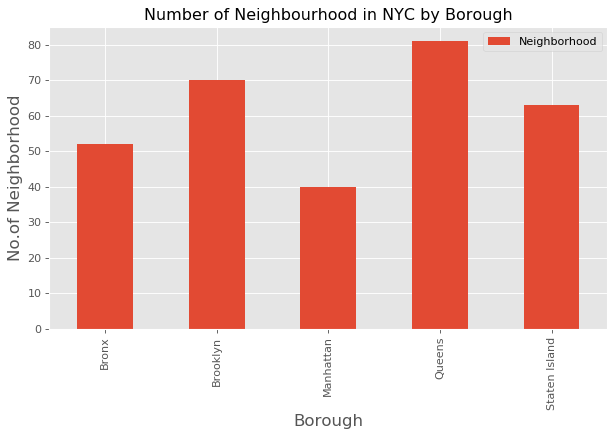

In [9]:
from matplotlib import pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(9,5), dpi = 80)
plt.title('Number of Neighbourhood in NYC by Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

Queens is densely populated borough in New York City with 80 neighborhoods

In [12]:
#indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:1
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:3
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Resturants in Bellerose, Queens:1
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

In [13]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [14]:
indian_rest_ny.shape

(143, 4)

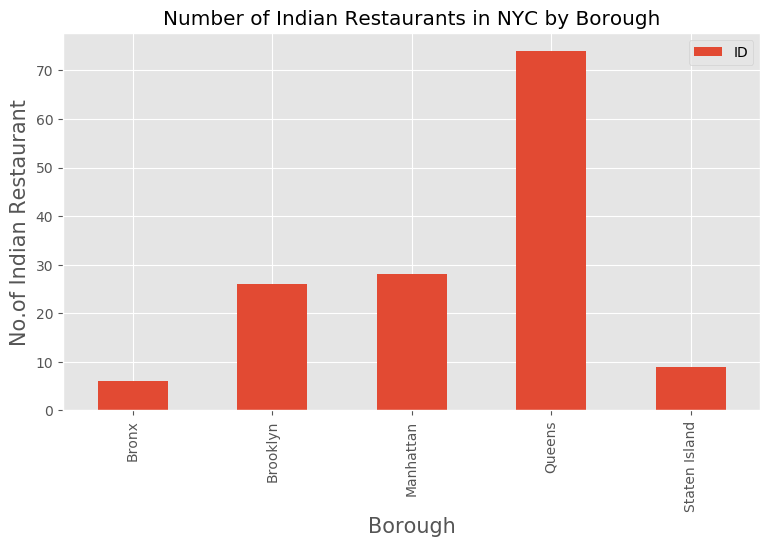

In [15]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Indian Restaurants in NYC by Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Indian Restaurant', fontsize=15)
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

So Queens has the max number of Indian Restaurants. 

In [16]:
indian_rest_ny2 = indian_rest_ny[indian_rest_ny['Borough']=='Queens']
indian_rest_ny2

,Borough,Neighborhood,ID,Name
49,Queens,Astoria,4aa56c81f964a5204e4820e3,Seva Indian Cuisine
50,Queens,Woodside,4afdcf29f964a520162b22e3,Rajbhog Sweets
51,Queens,Woodside,4c7060e734443704ca0e245f,Kababish
52,Queens,Woodside,4b998d3ff964a520fc8235e3,Maharaja Sweets & Snacks
53,Queens,Woodside,4b189424f964a52043d423e3,Dera
54,Queens,Woodside,5da4fbf091a08400078be19d,Angel Indian Restaurant
55,Queens,Woodside,49ebb18ff964a52016671fe3,Delhi Heights
56,Queens,Woodside,4e334b7bb0fb17f64f81a8b2,Premium Sweets & Restaurant
57,Queens,Jackson Heights,527d9cbc498edf0db10bde6b,Samudra
58,Queens,Jackson Heights,4afdcf29f964a520162b22e3,Rajbhog Sweets


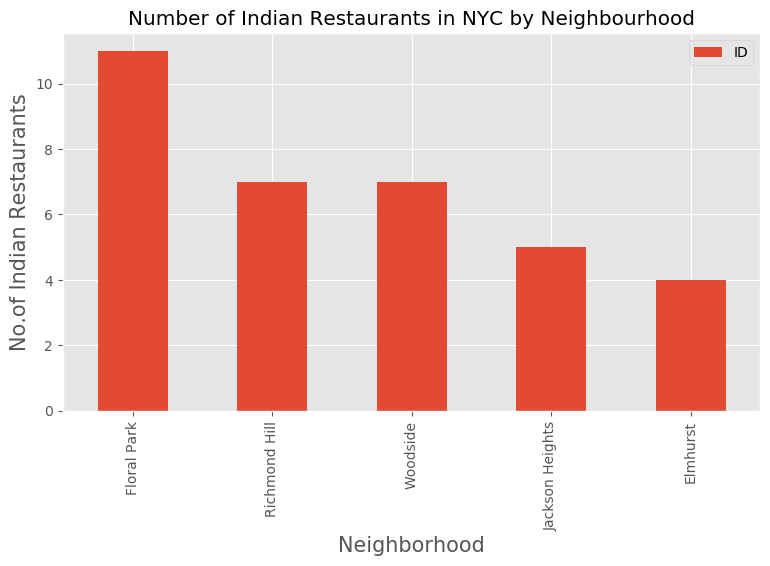

In [17]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Indian Restaurants in NYC by Neighbourhood')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Indian Restaurants', fontsize=15)
indian_rest_ny2.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

and neighbourhood containing max restaurants is Floral park

In [90]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in indian_rest_ny2.values.tolist():
    Borough,Neighborhood,ID,Name=row

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

for row in indian_rest_ny2.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        id,name,likes,rating,tips=[0]*5
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True);
    count+=1

''

In [64]:
indian_rest_stats_ny

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Queens,Astoria,4aa56c81f964a5204e4820e3,Seva Indian Cuisine,239,9.0,133
1,Queens,Woodside,4afdcf29f964a520162b22e3,Rajbhog Sweets,37,8.5,25
2,Queens,Woodside,4c7060e734443704ca0e245f,Kababish,30,7.8,17
3,Queens,Woodside,0,0,0,0.0,0
4,Queens,Woodside,0,0,0,0.0,0
5,Queens,Woodside,5da4fbf091a08400078be19d,Angel Indian Restaurant,10,8.0,1
6,Queens,Woodside,49ebb18ff964a52016671fe3,Delhi Heights,34,7.8,24
7,Queens,Woodside,4e334b7bb0fb17f64f81a8b2,Premium Sweets & Restaurant,11,7.4,6
8,Queens,Jackson Heights,527d9cbc498edf0db10bde6b,Samudra,49,8.7,16
9,Queens,Jackson Heights,4afdcf29f964a520162b22e3,Rajbhog Sweets,37,8.5,25


In [65]:
indian_rest_stats_ny.shape

(74, 7)

In [66]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Queens,Astoria,4aa56c81f964a5204e4820e3,Seva Indian Cuisine,239,9.0,133
1,Queens,Woodside,4afdcf29f964a520162b22e3,Rajbhog Sweets,37,8.5,25
2,Queens,Woodside,4c7060e734443704ca0e245f,Kababish,30,7.8,17
3,Queens,Woodside,0,0,0,0.0,0
4,Queens,Woodside,0,0,0,0.0,0


In [67]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       74 non-null     object 
 1   Neighborhood  74 non-null     object 
 2   ID            74 non-null     object 
 3   Name          74 non-null     object 
 4   Likes         74 non-null     object 
 5   Rating        74 non-null     float64
 6   Tips          74 non-null     object 
dtypes: float64(1), object(6)
memory usage: 4.2+ KB


In [68]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [69]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [70]:
indian_rest_stats_ny['Rating']=indian_rest_stats_ny['Rating'].astype('float64')

In [71]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       74 non-null     object 
 1   Neighborhood  74 non-null     object 
 2   ID            74 non-null     object 
 3   Name          74 non-null     object 
 4   Likes         74 non-null     float64
 5   Rating        74 non-null     float64
 6   Tips          74 non-null     float64
dtypes: float64(3), object(4)
memory usage: 4.2+ KB


maximum Likes

In [72]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                           Queens
Neighborhood                     Astoria
ID              4aa56c81f964a5204e4820e3
Name                 Seva Indian Cuisine
Likes                                239
Rating                                 9
Tips                                 133
Name: 0, dtype: object

In [73]:
indian_rest_stats_ny['Rating']

0     9.0
1     8.5
2     7.8
3     0.0
4     0.0
5     8.0
6     7.8
7     7.4
8     8.7
9     8.5
10    8.3
11    8.0
12    7.8
13    8.7
14    8.0
15    7.8
16    7.4
17    7.9
18    7.5
19    7.6
20    7.9
21    7.3
22    6.0
23    0.0
24    5.8
25    0.0
26    7.7
27    9.0
28    7.0
29    9.0
30    8.2
31    7.6
32    0.0
33    8.2
34    8.2
35    6.7
36    0.0
37    6.7
38    0.0
39    5.9
40    0.0
41    7.6
42    8.0
43    7.0
44    8.0
45    7.3
46    7.0
47    8.2
48    8.1
49    8.4
50    7.5
51    7.5
52    6.8
53    5.9
54    0.0
55    0.0
56    5.9
57    0.0
58    0.0
59    8.5
60    7.3
61    0.0
62    0.0
63    8.1
64    7.0
65    8.0
66    7.3
67    7.0
68    0.0
69    0.0
70    0.0
71    9.0
72    7.7
73    7.0
Name: Rating, dtype: float64

In [74]:
indian_rest_stats_ny.sort_values(['Rating'],ascending=False).head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Queens,Astoria,4aa56c81f964a5204e4820e3,Seva Indian Cuisine,239.0,9.0,133.0
29,Queens,Sunnyside,5b931ea69d7468002c3b1382,Adda,129.0,9.0,35.0
27,Queens,Long Island City,5b931ea69d7468002c3b1382,Adda,129.0,9.0,35.0
71,Queens,Blissville,5b931ea69d7468002c3b1382,Adda,129.0,9.0,35.0
8,Queens,Jackson Heights,527d9cbc498edf0db10bde6b,Samudra,49.0,8.7,16.0


###### All the neighborhoods with average rating greater or equal 8.0 to be visualized on map

In [75]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [76]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [77]:
ny_neighborhood_stats 

,Neighborhood,Average Rating
0,Astoria,9.00
4,Blissville,9.00
10,Holliswood,8.50
11,Jackson Heights,8.26
19,Ravenswood,8.10
22,Ridgewood,8.20
23,Steinway,8.20
24,Sunnyside,9.00


In [78]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [79]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [80]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,9.00
1,Queens,Blissville,40.737251,-73.932442,9.00
7,Queens,Sunnyside,40.740176,-73.926916,9.00
8,Staten Island,Sunnyside,40.612760,-74.097126,9.00
2,Queens,Holliswood,40.720957,-73.767142,8.50
3,Queens,Jackson Heights,40.751981,-73.882821,8.26
5,Queens,Ridgewood,40.708323,-73.901435,8.20
6,Queens,Steinway,40.775923,-73.902290,8.20
4,Queens,Ravenswood,40.761705,-73.931575,8.10


Create folium map

In [81]:
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [82]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [83]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

Neighbourhoods in New York having high average rating for Indian Restaurants.

In [84]:
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
ny_map.add_child(incidents)

Findings 
1. Murray Hill, Tribeca, Midtown in Manhattan are some of the best neighborhoods for Indian cuisine. 
2. Bronx has the lowest rated Indian Resturants in NYC.
3. Manhattan is the best place to stay if you prefer Indian Cuisine.